# Flatiron School DS-Flex Phase Three Milestone

## Business Case Overview

### The Company

Sigma Airlines is the leading consumer aviation transportion service, providing the best value in customer experience and comfort. In order to contiune leading the industry in customer satisfaction Sigma Airlines is taking steps to make more data-driven decisions around how to continually improve the way its customers are served.  

### The Use Case

The Sigma Airlines E.V.P. and Chief Customer Service Officer, Madison Housend, wishes to better understand the differences in behaviour, and impression of services rendered, between habitual return ('loyal') and non-return ('disloyal') customers. Housend wishes to understand what services should be improved in order to retain more customer loyalty (i.e. increase churn rate of disloyal-to-loyal customers). Housend, an avid supporter of women's rights, also is interested in *if* loyalty dynamics differ between genders; if so, understanding the difference may aid in taking actions that make Sigma airlines an even safer and more comfortable choice for women, naturally increaseing loyalty within the female demographic. 

## Data Overview

The data used for the ML development involved in this analysis is sourced from this [kaggle]("https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?select=train.csv") dataset. It is a dataset of over 100k records. Each record represents an individual customer, the details of their flight (e.g. distance, delay time), and survey responses regarding their satisfaction with the services rendered while boarding, in-flight and deboarding.   

The details of the preprocessing steps taken for this project are provided in the [EDA notebook](./development/EDA.ipynb) and [resampling notebook](./development/resampling.ipynb), which are both located in the development/ folder of this repository. Additionally detailed descriptions of the *raw data* features and their summary statistics (ranges, averages, etc.) can be found in the [data dictionary](./data/dictionary.md) located in the data/ folder. 

To summarize:  
    - The selected target feature is the column titled "Customer Type".  
    - The target feature is binary (Loyal/disloyal), and the target class is "disloyal". Disloyal is represented as 1, after one-hot-encoding.  
    - The target class is highly imbalanced with only about 18% of the raw training data being labeled as disloyal. The training data only is resampled using SMOTEENN, and ensemble of oversampling the target class with SMOTE and undersampling the non-target class with ENN.  
    - There are 4 features used that contain continuous data, providing details of the flight itself.  
    - There are another 18 features used that contain categorical data providing information on the customer themself and their trip (e.g. gender, purpose for travel) as well as the survey responses the customer provided.  


In [2]:
import pandas as pd
raw_df = pd.read_csv("./data/train.csv.zip",compression='zip',index_col=0).drop('id',axis=1)
raw_df.head()


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## Data Understanding

### Data Cleaning and Preprocessing

The code used to execute the preprocessing has been packaged into a module called [preprocessor](./development/preprocessor.py), located in the development/ folder along with other ML and EDA development notebooks. The preprocessor module contains two functions, data_cleaner() and data_sampler().  

The data_cleaner() function is commented step by step in the preprocessor module linked above. The process of developing this function can be found in the [EDA notebook](#data-overview) also linked above.  
The data_cleaner() highlights are:  
- The survey is on a scale of 1-5, some zeros were present which were being interpreted as NaN values. The data description found on Kaggle with the data source states that these were "N/A" answers. I imputed these zeros as the mode of the rest of the survey answers in a given row, based on the assumption that whatever a surveyee's most common answer is, it is more likely they would provide that same answer than any other value for a given survey question. This technique *does not eliminate all the zeros* but it reduces the total records within the survey features that contain zeros from over eight thousand to less than three hundred. My intentions here were to deal with the NaN issue, while maintaining the integrity of the scaling of the survey data (1-5), as well as keeping the imputed survey responses aligned with the disposition of the relevant surveyee, I suspect that the rows that still have zeros after data cleaning are such because most of the answers provide for that record were infact zero. 
- Some arrival delays were NaN values. Considering that departure delays had zero NaNs but many zeros. I made the assumption that these NaN values were infact flights were there was not a delay (so no delay time was recorded). So to eliminate NaNs, again for the sake of modeling, while keeping consistent with the nature of the raw data I replaced the missing values here simply with numerical zeros. 
- Lastly, I performed one-hot-encoding (using pandas) on categorical features including the target feature, *but not the survey features*. I chose to not OHE the survey because although it is categorical it is numerical and *ordinal* meaning there is a significance of scale between one answer choice and the others, not simply a boolean realtionship. (i.e. 4 is greater than 3 and even more so than 2, not simply just not 3 and just not 2).

In [3]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import development.preprocessor as pre

X_train, y_train = pre.data_cleaner("./data/train.csv.zip")
X_test, y_test = pre.data_cleaner("./data/test.csv.zip")


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [4]:
# raw training data preview
X_train.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,13,460,3,4,3,1,5,3,5,5,...,4,5,5,25,18.0,1,1,0,1,0
1,25,235,3,2,3,3,1,3,1,1,...,1,4,1,1,6.0,1,0,0,0,0
2,26,1142,2,2,2,2,5,5,5,5,...,4,4,5,0,0.0,0,0,0,0,1
3,25,562,2,5,5,5,2,2,2,2,...,1,4,2,11,9.0,0,0,0,0,0
4,61,214,3,3,3,3,4,5,5,3,...,3,3,3,0,0.0,1,0,0,0,1


In [5]:
# Summary statistics on training data
X_train.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,...,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,2.816985,3.213707,2.884239,2.976892,3.204872,3.316956,3.439434,3.358292,...,3.304329,3.640457,3.286495,14.815618,15.133392,0.492541,0.310373,0.449886,0.072124,0.433333
std,15.114964,997.147281,1.267507,1.390750,1.307256,1.277602,1.326754,1.275760,1.319046,1.332810,...,1.265356,1.175610,1.312098,38.230901,38.649776,0.499947,0.462649,0.497485,0.258695,0.495538
min,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,...,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,...,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data Resampling

In the resampling notebook (linked in the overview section) I trained a series of logistic regression models. The only difference between the models is how the method of resampling used on the training data. The hyperparameters were all the same, the test data was not resampled but was cleaned using the data_cleaner() function.  

I selected the SMOTEENN algorithm based mainly on its impact on the model's F1 score, shown here:
![F1 Scores](./images/f1_resamples.png "F1 Score by Resample Strategy")  
As well as its impact on the area under the model's receiver operating characteristic curve (ROC AUC). The ROC AUC on the models' fits of the training data showed SMOTEENN to be the highest performer:  
Fig. 1|Fig. 2
-|-
![Training ROC AUC](./images/resample_train_rocauc.png "ROC AUC by Resample Strategy")|![Test ROC AUC](./images/resample_traintest_rocauc.png "ROC AUC by Resamply Strategy (test)")  

After evaluating the highest performing ensemble method (SMOTEENN) and the highest performing non-ensemble method (Near Miss) against the test data set, there was a significant decrease in F1-score by both models (near miss more so). Upon inspection of the testing ROC AUC of each candidate it was obvious that SMOTEENN was able to generalize to unseen data much better than  Near Miss. Simply put, the SMOTEENN model performed on the test data as well as the Near Miss model performed only on the training data (see fig. 2). With these discoveries I selected SMOTEENN as my resampling method for the remainder of the project and wrote the data_sampler() function to make the resampling method portable and consistent between notebooks. 

The data_sampler() function has minimal commenting, however the logic flow is extremely simple and the imblearn library documentation can provide robust explanations of the algorithms being utilized. After an exploratory analysis of various resampling methods passed into a very basic logistic regression model I selected the SMOTEENN algorithm based on its affect on F1-score and ROC AUC compared to other resampling algorithms. I only wrote a function to perform this step so that I could manually set the sampling strategy used once.  
The [SMOTEENN](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html) algorithm ensembles oversampling with [Synthetic Minority OvEr-sampling](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html?highlight=smote#imblearn.over_sampling.SMOTE) which uses a distance based algorithm to synthesize new data points that are "close" to the original data points, and undersampling the majority class with [Edited Nearest Neighbors](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html?highlight=enn) which uses a distance based algorithm that takes the k-nearest data points to a minority data point and eliminates any of those neighboring observations that belong to the majority class.  

Its important for me to emphasize that **only the training data is resampled** I do not resample the testing data, I only clean it using the data_cleaner() function. So the train and test data are cleaned the exact same way, but the training data retains its original class imbalance (which is relatively proportional to imbalance of the raw training data)

In [6]:
X_resample, y_resample = pre.data_sampler(X_train,y_train)

In [7]:
X_resample.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
0,13,460,3,4,3,1,5,3,5,5,...,4,5,5,25,18.0,1,1,0,1,0
1,61,214,3,3,3,3,4,5,5,3,...,3,3,3,0,0.0,1,0,0,0,1
2,52,2035,4,3,4,4,5,5,5,5,...,4,5,4,4,0.0,0,0,0,0,1
3,12,308,2,4,2,2,1,2,1,1,...,5,5,1,0,0.0,0,1,0,1,0
4,53,834,1,4,4,4,1,1,1,1,...,4,4,1,28,8.0,1,0,1,0,0


In [8]:
X_resample.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Type of Travel_Personal Travel,Class_Eco,Class_Eco Plus,satisfaction_satisfied
count,137296.000000,137296.000000,137296.000000,137296.000000,137296.000000,137296.000000,137296.000000,137296.000000,137296.000000,137296.000000,...,137296.000000,137296.000000,137296.000000,137296.000000,137296.000000,137296.000000,137296.000000,137296.00000,137296.000000,137296.000000
mean,35.858088,1048.406261,2.657332,2.877702,2.702883,2.821277,2.980262,2.967588,3.104402,3.075669,...,3.117243,3.528544,3.041312,14.203342,14.591728,0.354686,0.117309,0.38964,0.029047,0.290882
std,14.426106,914.249384,1.203245,1.294365,1.230625,1.147400,1.299361,1.271292,1.332736,1.325320,...,1.201847,1.090508,1.299639,36.721730,37.185702,0.478420,0.321789,0.48767,0.167938,0.454171
min,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,24.000000,391.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,35.000000,733.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,46.000000,1379.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,11.000000,12.203564,1.000000,0.000000,1.00000,0.000000,1.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,1305.000000,1280.000000,1.000000,1.000000,1.00000,1.000000,1.000000


### Visualizations of the Impact of Resampling with SMOTEENN
These data visualization below illustrate the impact of the SMOTEENN resampling algorithm on the relative weights and distributions of values and/or classes amongst the various features.

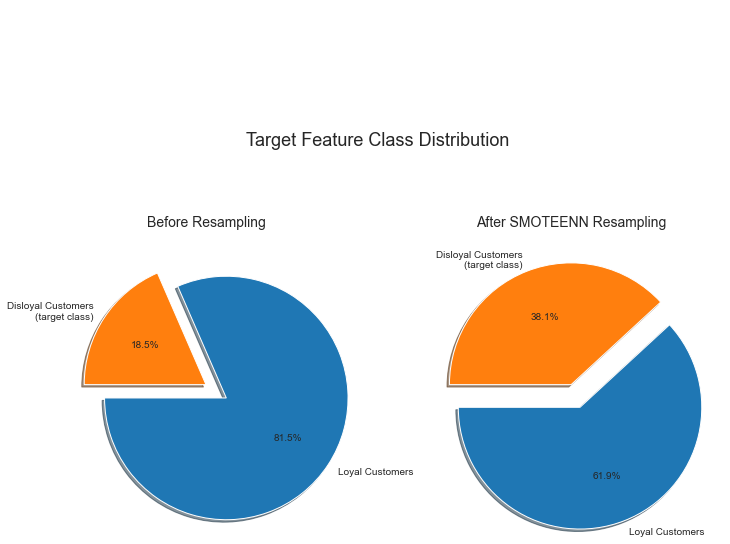

In [9]:
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
fig,axs = plt.subplots(1,2)
axs[0].pie(y_test.value_counts(normalize=True),
        labels=['Loyal Customers','Disloyal Customers\n(target class)'],
        startangle=180,
        shadow=True,
        explode=[.2,0],
        autopct='%1.1f%%')
axs[0].set_title("Before Resampling",fontsize=14)

axs[1].pie(y_resample.value_counts(normalize=True),
        labels=['Loyal Customers','Disloyal Customers\n(target class)'],
        startangle=180,
        shadow=True,
        explode=[.2,0],
        autopct='%1.1f%%')
axs[1].set_title("After SMOTEENN Resampling",fontsize=14)

fig.suptitle("\n\n\n\n\n\nTarget Feature Class Distribution",fontsize=18)
fig.set_size_inches(12,11)
plt.subplots_adjust(wspace=0.2)
plt.show()

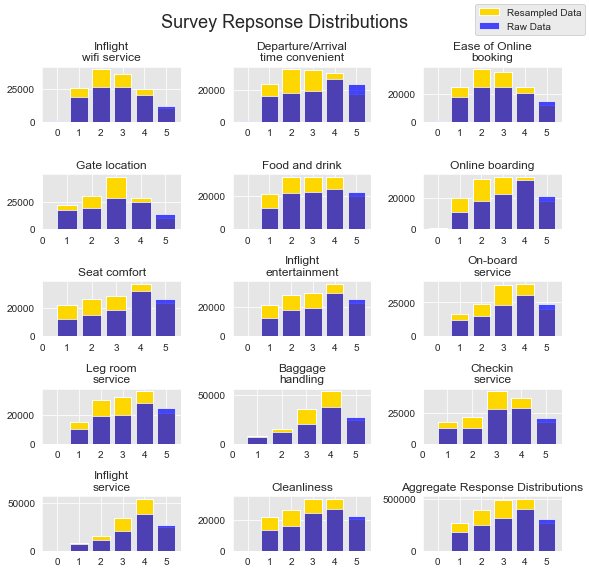

In [10]:
survey_df = X_train.iloc[:,2:16]
resample_survey_df = X_resample.iloc[:,2:16]

survey_labels = [
    'Inflight\nwifi service', 
    'Departure/Arrival\ntime convenient',
    'Ease of Online\nbooking', 
    'Gate location', 
    'Food and drink',
    'Online boarding', 
    'Seat comfort', 
    'Inflight\nentertainment', 
    'On-board\nservice', 
    'Leg room\nservice', 
    'Baggage\nhandling', 
    'Checkin\nservice', 
    'Inflight\nservice', 
    'Cleanliness']

fig, axes = plt.subplots(5,3)
row = 0
column = 0

for idx,col in enumerate(resample_survey_df.columns):

    raw = survey_df[col].value_counts().to_dict()
    resample = resample_survey_df[col].value_counts().to_dict()

    axes[row,column].bar(x=list(resample.keys()),height=list(resample.values()),color='gold')
    axes[row,column].bar(x=list(raw.keys()),height=list(raw.values()),color='blue',alpha=0.7)
    axes[row,column].set_title(survey_labels[idx])
    axes[row,column].set_xticks([0,1,2,3,4,5])

    column += 1 
    if column > 2:
        row += 1
        column = 0 

survey_count_dict = {1:0,2:0,3:0,4:0,5:0,0:0}
resample_survey_count_dict = {1:0,2:0,3:0,4:0,5:0,0:0}

for key in survey_count_dict.keys():
    survey_count_dict[key] += (survey_df.values==key).sum()
    resample_survey_count_dict[key] += (resample_survey_df.values==key).sum()

axes[4,2].bar(x=list(resample_survey_count_dict.keys()),height=list(resample_survey_count_dict.values()),color='gold')
axes[4,2].bar(x=list(survey_count_dict.keys()),height=list(survey_count_dict.values()),color='blue',alpha=0.7)
axes[4,2].set_title("Aggregate Response Distributions")
axes[4,2].set_xticks([0,1,2,3,4,5])

fig.set_size_inches(8, 8)
fig.suptitle("Survey Repsonse Distributions",fontsize=18)
fig.tight_layout()
fig.legend(loc='upper right',labels=['Resampled Data','Raw Data'])
plt.show()

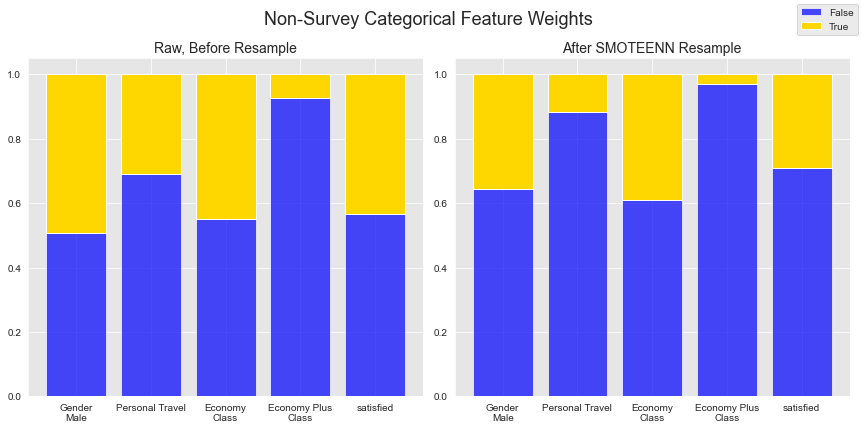

In [11]:
features = ['Gender_Male','Type of Travel_Personal Travel','Class_Eco','Class_Eco Plus','satisfaction_satisfied']
labels = ['Gender\nMale','Personal Travel','Economy\nClass','Economy Plus\nClass','satisfied']

raw_ones = []
raw_zeros = []

for idx,label in enumerate(labels):
    series = X_train[features[idx]].value_counts(normalize=True)
    raw_ones.append(series[1])
    raw_zeros.append(series[0])

resample_ones = []
resample_zeros = []

for idx,label in enumerate(labels):
    series = X_resample[features[idx]].value_counts(normalize=True)
    resample_ones.append(series[1])
    resample_zeros.append(series[0])   
    
# fig.set_size_inches(8, 8)
fig,axs = plt.subplots(1,2)
axs[0].bar(labels,raw_zeros,label='False',color='blue',alpha=.7)
axs[0].bar(labels,raw_ones,label='True',bottom=raw_zeros,color='gold')
axs[0].set_title('Raw, Before Resample',fontsize=14)

axs[1].bar(labels,resample_zeros,label='False',color='blue',alpha=.7)
axs[1].bar(labels,resample_ones,label='True',bottom=resample_zeros,color='gold')
axs[1].set_title('After SMOTEENN Resample',fontsize=14)

fig.legend(['False','True'])
fig.set_size_inches(12, 6)
fig.suptitle("Non-Survey Categorical Feature Weights",fontsize=18)
fig.tight_layout()
plt.show()

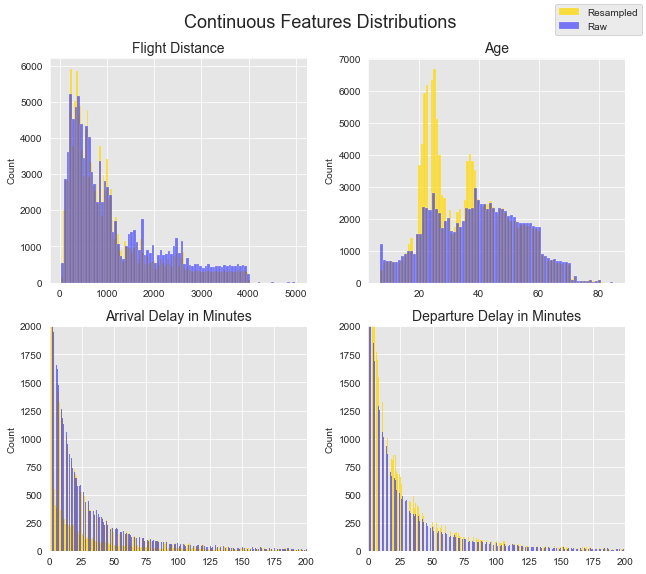

In [12]:
fig,axs = plt.subplots(2,2)

#Flight distance
ff = sns.histplot(data=X_resample['Flight Distance'],ax=axs[0,0],color='gold')
f = sns.histplot(data=X_train['Flight Distance'],ax=axs[0,0],color='blue',alpha=.5).set_title('Flight Distance',fontsize=14)
axs[0,0].set_xlabel("")

#age
aa = sns.histplot(data=X_resample['Age'],ax=axs[0,1],color='gold')
a = sns.histplot(data=X_train['Age'],ax=axs[0,1],color='blue',alpha=.5).set_title('Age',fontsize=14)
axs[0,1].set_xlabel("")

#Arrival Delay in Minutes
dede = sns.histplot(data=X_resample['Arrival Delay in Minutes'],ax=axs[1,0],color='gold')
de = sns.histplot(data=X_train['Arrival Delay in Minutes'],ax=axs[1,0],color='blue',alpha=.5).set_title('Arrival Delay in Minutes',fontsize=14)
axs[1,0].set_xlabel("")
axs[1,0].set_ylim(0,2000)
axs[1,0].set_xlim(0,200)

#Departure Delay in Minutes
dldl = sns.histplot(data=X_resample['Departure Delay in Minutes'],ax=axs[1,1],color='gold')
dl = sns.histplot(data=X_train['Departure Delay in Minutes'],ax=axs[1,1],color='blue',alpha=.5).set_title('Departure Delay in Minutes',fontsize=14)
axs[1,1].set_xlabel("")
axs[1,1].set_ylim(0,2000)
axs[1,1].set_xlim(0,200)

fig.suptitle("Continuous Features Distributions",fontsize=18)
fig.legend(['Resampled','Raw'])
fig.set_size_inches(9, 8)
fig.tight_layout()
plt.show()

### Tree-Based Model Development and Selection

After selecting a resampling strategy, my next step was to discover the optimal tree-based model and related hyper parameters. I performed this investigation in the [gridsearching notebook](./development/gridsearching.ipynb) found in the development/ folder of this repository, I discovered optimal hyperparameters using SciKit-Learn's [GridsearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function and searching different grids in an iterative manner. After fitting each gridsearch I evaluated the optimized model against the test data, focusing primarily -again- on F1-score and ROC AUC. 

It turned out that the baseline Random Forest (sans hyperparameter tuning) was the strongest performer according to the F1-score. It should be noted that the computational expense of a gridsearch on a Random Forest on my machine was too great. So the Random Forest was not gridsearch but I experimented manually with some hyperparameters, using the best parameters found for the solo Decision Tree as a guideline. I found that any adjustments I made to the model only worsened its performance. The F1-score for the various tree-based models inspected is visualized below: 
![F1-Score Tree Based Models](./images/tree_based_f1scores.png)

The curve of the ROC AUC scores was quite acute, which made me suspicous of overfitting... however the confusion matrices associated with each model gave me some peace of mind in that regard. It should be noted that the following ROC curves are of the model's performance with the test data. Nonetheless, the trainin data set alone is over 150 thousand records, so at this point the ROC curves should be taken with a grain of salt. However the visualization below certainly demonstrates the models' performance relative to one another at least.  
![Tree-Based ROC curves](./images/tree_based_rocauc.png)

As a final attempt at validating that the Random Forest, with its default hyperparameter values, is in fact the highest performing model, I plotted the rate of correct and incorrect predictions by each model. The following visualization essentially shows how each model's confusion matrix compares to the others. Even here the basline Random Forest is the obvious best performer. Again, the following visualization represents each model's performance on the test data.  
![Prediction Performance](./images/tree_based_TF_rates.png)

## Final Model Evaluation and Interpretation

In [21]:
# import dependencies
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

In [15]:
# instantiate and fit model
RFC = RandomForestClassifier(n_jobs=3)
RFC.fit(X_resample,y_resample)

RandomForestClassifier(n_jobs=3)

### Evaluate Performance on Training Data

In [29]:
# evalute on training predictions
train_pred = cross_val_predict(RFC,X_train,y_train,n_jobs=3)
rfc_train_report = classification_report(y_train,train_pred,output_dict='true')
rfc_report = pd.DataFrame(rfc_train_report).iloc[:,0:3]
rfc_report

,0,1,accuracy
precision,0.986468,0.976174,0.984659
recall,0.994878,0.938939,0.984659
f1-score,0.990655,0.957194,0.984659
support,84923.000000,18981.000000,0.984659


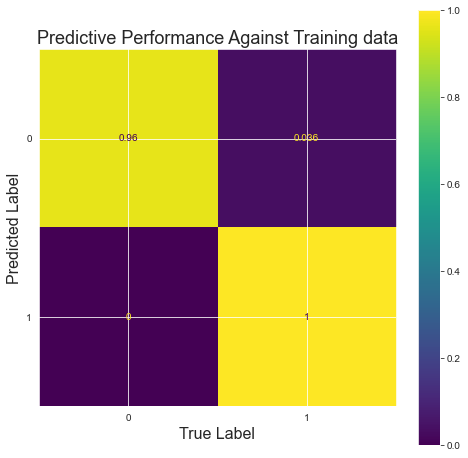

In [55]:


fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(RFC,X_train,y_train,normalize='true',ax=ax)
ax.set_title("Predictive Performance Against Training data",fontsize=18)
ax.set_xlabel('True Label',fontsize=16)
ax.set_ylabel('Predicted Label',fontsize=16)

plt.show()

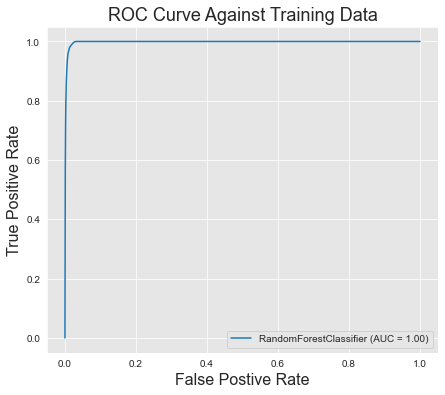

In [44]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_roc_curve(RFC,X_train,y_train,ax=ax)
plt.title("ROC Curve Against Training Data",fontsize=18)
plt.xlabel('False Postive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.show()